<div style="background-color:#BFBEBE; text-align: center;">
<img src="imgs/icon.png" style="width:600px">
</div>

# Clustering

In [ ]:
!curl https://meriatdatasets.blob.core.windows.net/public/digital-audio-processing/drum_samples.zip -o audios/drum_samples.zip
!curl https://meriatdatasets.blob.core.windows.net/public/digital-audio-processing/125_bounce.wav -o audios/125_bounce.wav

In [ ]:
!unzip audios/drum_samples.zip -d audios

In [ ]:
!rm audios/drum_samples.zip
!ls audios/drum_samples

In [23]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import librosa, librosa.display
import IPython.display as ipd

import sklearn.preprocessing as sklp
import sklearn.cluster as sklc
import sklearn as skl

from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

Paper da criação do pacote **`mir_eval`**.

[A TRANSPARENT IMPLEMENTATION OF COMMON MIR METRICS](https://colinraffel.com/publications/ismir2014mir_eval.pdf)

Documentação: http://craffel.github.io/mir_eval/

In [3]:
import mir_eval

# Basic Feature Extraction

De alguma forma, devemos extrair as características do nosso sinal de áudio que são mais relevantes para o problema que estamos tentando resolver. 

Por exemplo, se quisermos classificar instrumentos por **timbre**, queremos características que possam nos ajudar a destinguir sons por seu **timbre** e não por seu **tom**.

> Este processo é conhecido como `extração de recursos` (feature extraction).

Para esta tarefa vamos analisar vinte arquivos de áudio: 

* dez amostras de **`kick drum`** ou **bumbo** 
* dez amostras de **`snare drum`** ou **caixa**

In [4]:
kick_signals = [ librosa.load(p)[0] for p in Path().glob('audios/drum_samples/train/kick_*.mp3') ]
snare_signals = [ librosa.load(p)[0] for p in Path().glob('audios/drum_samples/train/snare_*.mp3') ]

print(len(kick_signals))
print(len(snare_signals))

10
10


#### Kick drum signals:

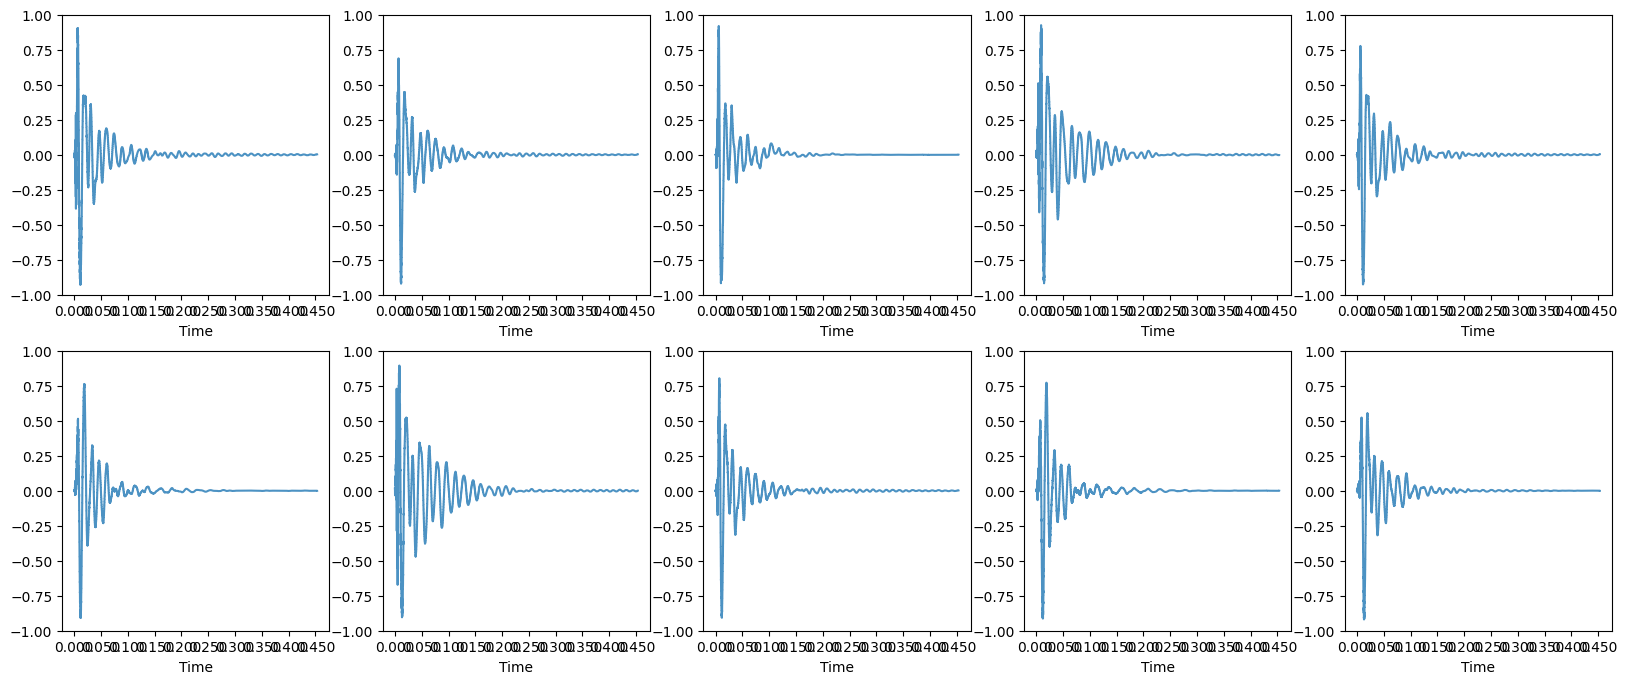

In [5]:
plt.figure(figsize=(20, 8))

for i, x in enumerate(kick_signals):
    plt.subplot(2, 5, i+1)
    librosa.display.waveshow(x[:10000], alpha=0.8)
    plt.ylim(-1, 1)

#### Snare drum signals

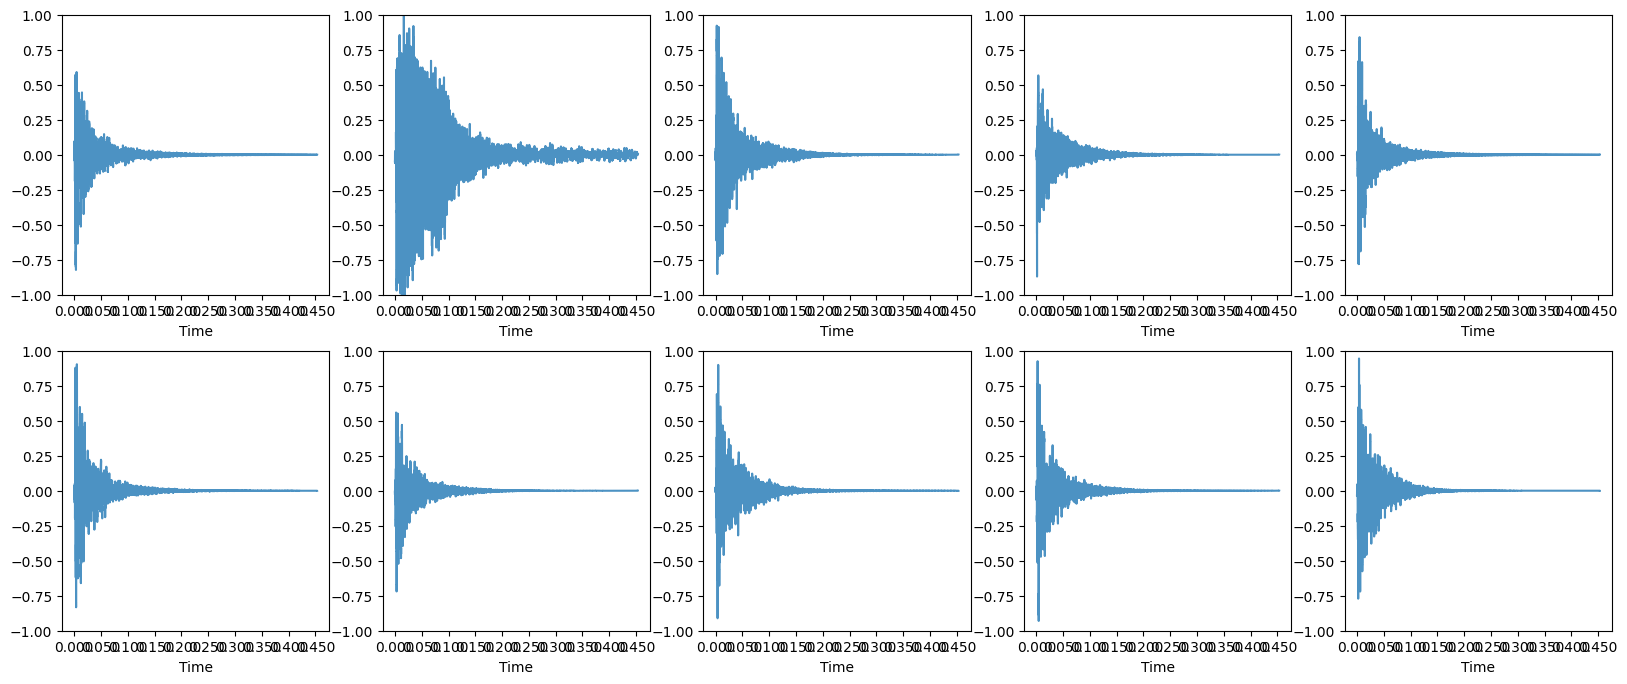

In [6]:
plt.figure(figsize=(20, 8))

for i, x in enumerate(snare_signals):
    plt.subplot(2, 5, i+1)
    librosa.display.waveshow(x[:10000], alpha=0.8)
    plt.ylim(-1, 1)

### Create a Feature Vector

Vamos criar um vetor de recursos (Feature Vector), para armazenar nossa coleção de recursos. 

Abaixo temos o método `extract_features`, que é uma função simples para construção de um vetor de recursos bidimensionais a partir de um determinado sinal:

In [7]:
def extract_features(signal):
    return [
        librosa.feature.zero_crossing_rate(y=signal)[0, 0],
        librosa.feature.spectral_centroid(y=signal)[0, 0]
    ]

In [8]:
kick_features = np.array([extract_features(x) for x in kick_signals])
snare_features = np.array([extract_features(x) for x in snare_signals])

#### Plot do histograma das características de cada uma das classes:

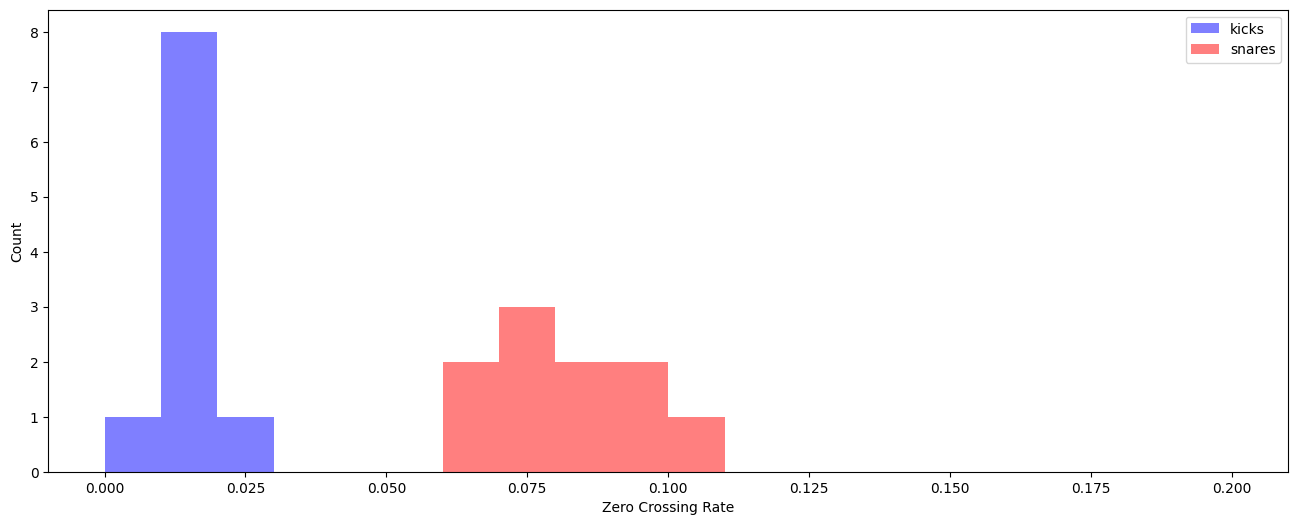

In [9]:
plt.figure(figsize=(16, 6))

plt.hist(kick_features[:,0], color='b', range=(0, 0.2), alpha=0.5, bins=20)
plt.hist(snare_features[:,0], color='r', range=(0, 0.2), alpha=0.5, bins=20)
plt.legend(('kicks', 'snares'))
plt.xlabel('Zero Crossing Rate')
plt.ylabel('Count')
plt.show()

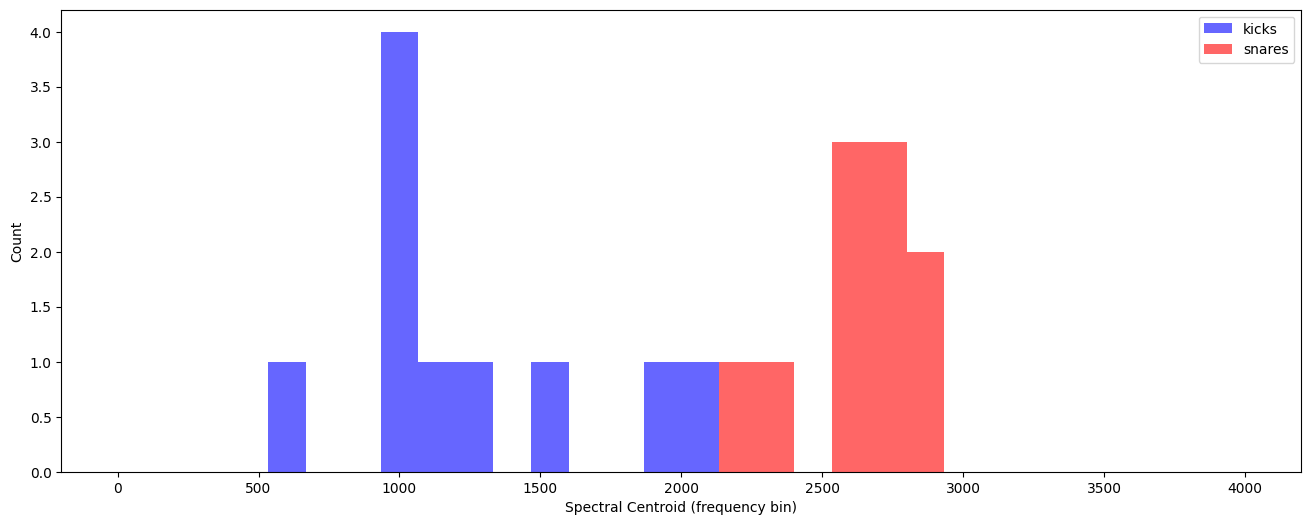

In [10]:
plt.figure(figsize=(16, 6))

plt.hist(kick_features[:,1], color='b', range=(0, 4000), bins=30, alpha=0.6)
plt.hist(snare_features[:,1], color='r', range=(0, 4000), bins=30, alpha=0.6)
plt.legend(('kicks', 'snares'))
plt.xlabel('Spectral Centroid (frequency bin)')
plt.ylabel('Count')
plt.show()

### Feature Scaling

As características que usamos no exemplo anterior incluíam a taxa de travessia no zero (zero crossing rate) e o centróide espectral (spectral centroid). Esses dois recursos são expressos usando unidades diferentes. Essa discrepância pode gerar problemas ao realizar uma classificação a posteriori. Portanto, normalizaremos cada vetor de recursos em uma faixa comum, armazenando também os parâmetros desta normalização para uso futuro.

Neste caso usaremos o `sklearn.preprocessing.MinMaxScaler`, que retorna uma série de valores escalonados de tal forma que cada dimensão do recurso está na faixa de -1 a 1.

In [12]:
feature_table = np.vstack((kick_features, snare_features))

print(feature_table.shape)

# Escalar cada dimensão de recurso para a faixa entre -1 e 1:
scaler =  sklp.MinMaxScaler(feature_range=(-1, 1))
training_features = scaler.fit_transform(feature_table)

print(training_features.min(axis=0))
print(training_features.max(axis=0))

(20, 2)
[-1. -1.]
[1. 1.]


#### Plot das características dimensionadas:

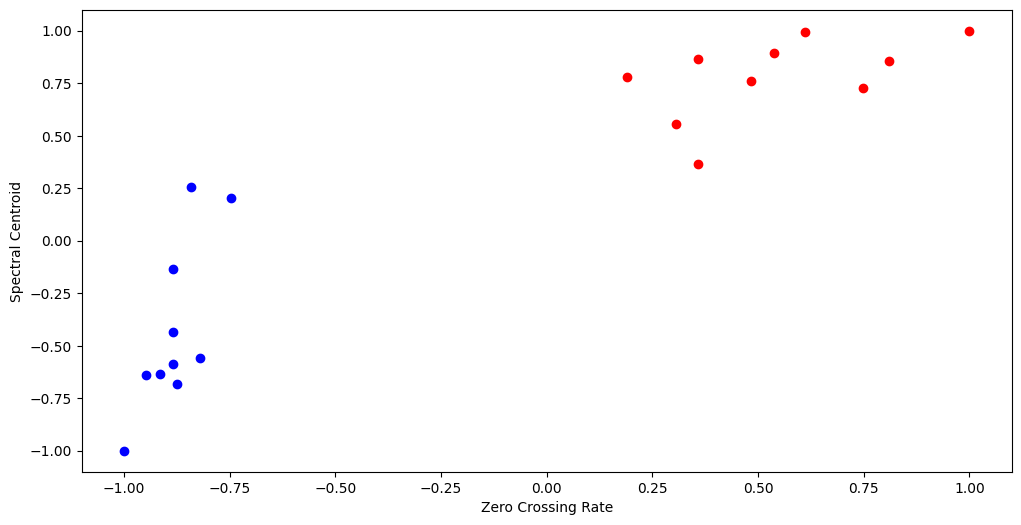

In [13]:
plt.figure(figsize=(12, 6))
plt.scatter(training_features[:10,0], training_features[:10,1], c='b')
plt.scatter(training_features[10:,0], training_features[10:,1], c='r')
plt.xlabel('Zero Crossing Rate')
plt.ylabel('Spectral Centroid')
plt.show()

# K-Means Clustering

Para este exemplo, vamos utilizar uma técnica de aprendizagem não supervisionada. Mesmo que seja abundante a quantidade de dados rotuládos, para a classificação ou outras atividades com áudio, queremos medir a precisão em que será possível agrupar nossos dados com base em suas características.

Para esta prova rápida, a técnica de clustering é uma ótima opção.

In [14]:
x, fs = librosa.load('audios/125_bounce.wav')
ipd.Audio(x, rate=fs)

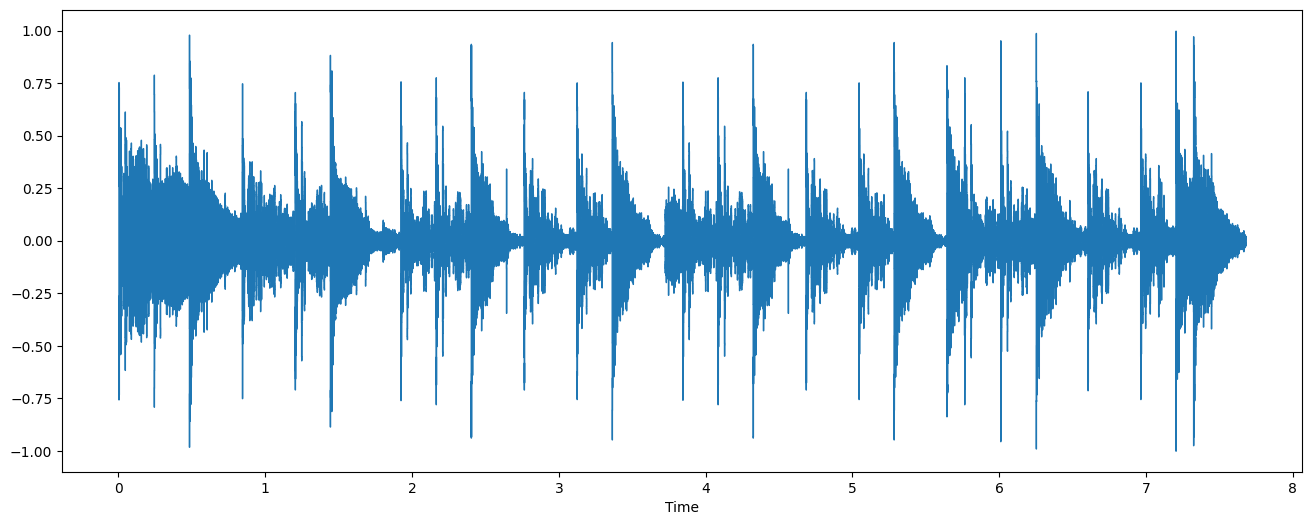

In [15]:
plt.figure(figsize=(16, 6))
librosa.display.waveshow(y=x, sr=fs)
plt.show()

### Onset Detection

In [16]:
onset_frames = librosa.onset.onset_detect(y=x, sr=fs, delta=0.04, wait=4)
onset_times = librosa.frames_to_time(onset_frames, sr=fs)
onset_samples = librosa.frames_to_samples(onset_frames)

In [17]:
x_with_beeps = mir_eval.sonify.clicks(onset_times, fs, length=len(x))
ipd.Audio(x + x_with_beeps, rate=fs)

### Feature Extraction

In [18]:
def extract_features(x, fs):
    zcr = librosa.zero_crossings(x).sum()
    energy = scipy.linalg.norm(x)
    return [zcr, energy]

In [19]:
frame_sz = int(fs*0.090)
a = [extract_features(x[i:i+frame_sz], fs) for i in onset_samples]
features = np.array(a)

print(features.shape)

(37, 2)


### Feature Scaling

In [20]:
min_max_scaler = sklp.MinMaxScaler(feature_range=(-1, 1))
features_scaled = min_max_scaler.fit_transform(features)

print(features_scaled.shape)
print(features_scaled.min(axis=0))
print(features_scaled.max(axis=0))

(37, 2)
[-1. -1.]
[1. 1.]


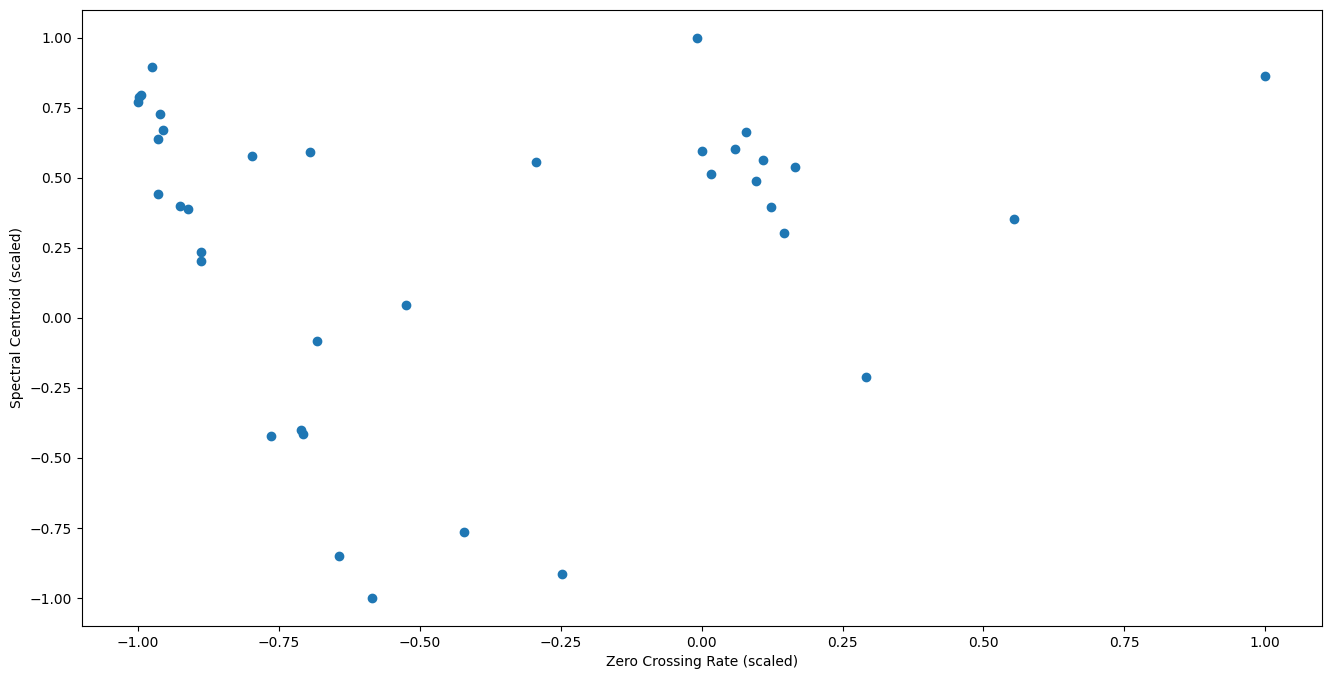

In [21]:
plt.figure(figsize=(16,8))
plt.scatter(features_scaled[:,0], features_scaled[:,1])
plt.xlabel('Zero Crossing Rate (scaled)')
plt.ylabel('Spectral Centroid (scaled)')
plt.show()

# Using K-Means

In [24]:
model = sklc.KMeans(n_clusters=2)
labels = model.fit_predict(features_scaled)

print(labels)

[1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1]


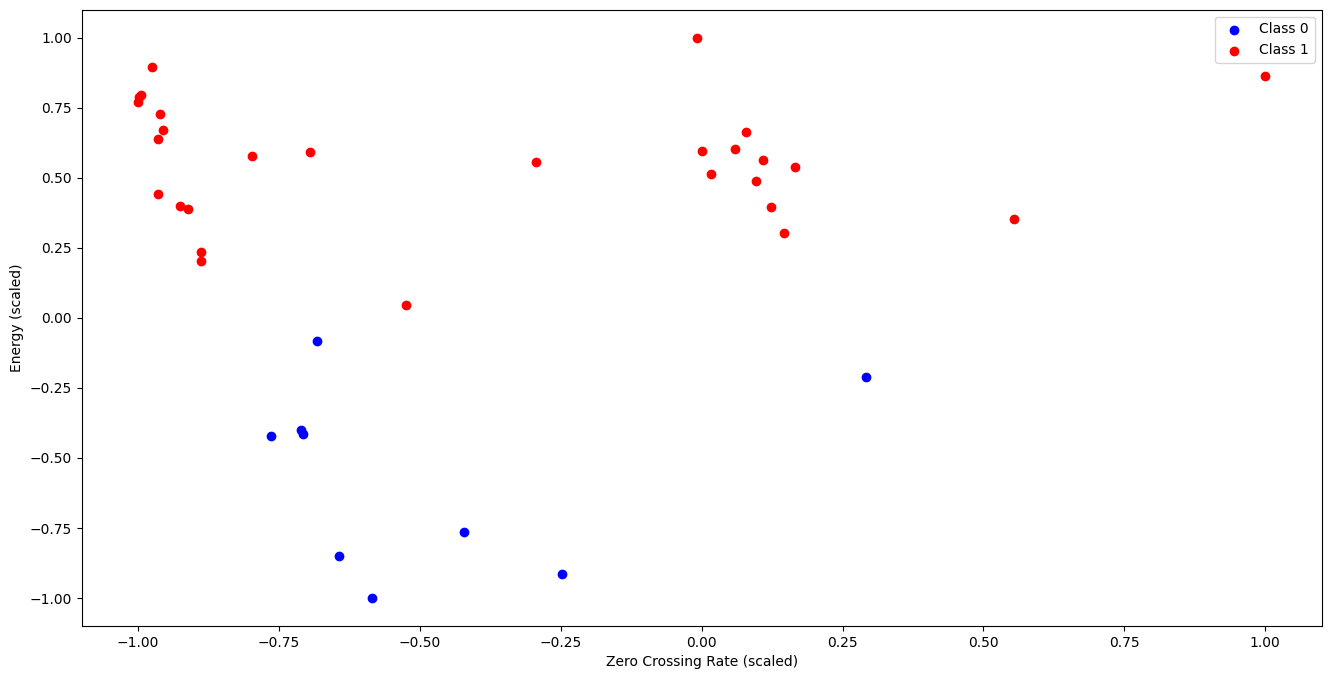

In [25]:
plt.figure(figsize=(16,8))
plt.scatter(features_scaled[labels==0,0], features_scaled[labels==0,1], c='b')
plt.scatter(features_scaled[labels==1,0], features_scaled[labels==1,1], c='r')
plt.xlabel('Zero Crossing Rate (scaled)')
plt.ylabel('Energy (scaled)')
plt.legend(('Class 0', 'Class 1'))
plt.show()

Listen to onsets assigned to Class 0:

In [26]:
x_with_beeps = mir_eval.sonify.clicks(onset_times[labels==0], fs, length=len(x))
ipd.Audio(x + x_with_beeps, rate=fs)

Class 1:

In [27]:
x_with_beeps = mir_eval.sonify.clicks(onset_times[labels==1], fs, length=len(x))
ipd.Audio(x + x_with_beeps, rate=fs)

### Affinity Propagation

In [28]:
model = sklc.AffinityPropagation(random_state=None)
labels = model.fit_predict(features_scaled)

print(labels)

[0 0 0 3 2 3 0 1 0 2 3 0 1 3 2 3 0 1 0 2 3 0 2 3 2 3 0 1 0 3 0 3 2 3 3 0 0]


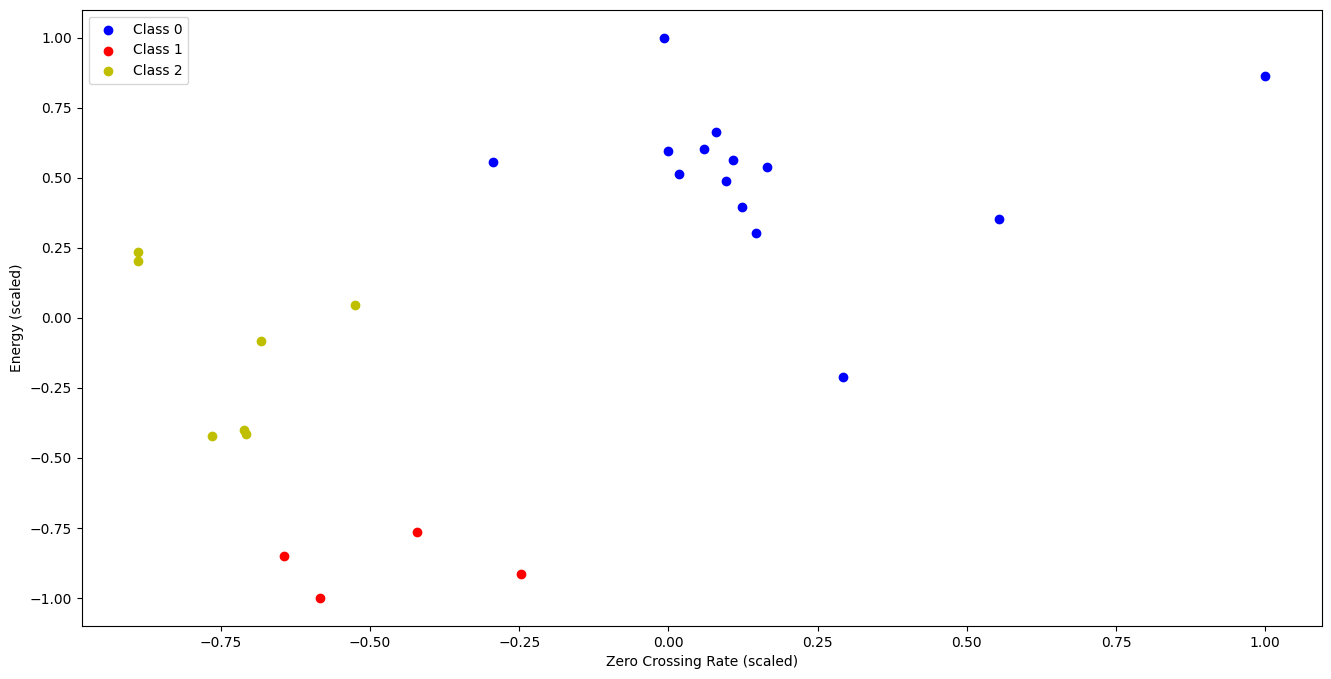

In [29]:
plt.figure(figsize=(16,8))
plt.scatter(features_scaled[labels==0,0], features_scaled[labels==0,1], c='b')
plt.scatter(features_scaled[labels==1,0], features_scaled[labels==1,1], c='r')
plt.scatter(features_scaled[labels==2,0], features_scaled[labels==2,1], c='y')
plt.xlabel('Zero Crossing Rate (scaled)')
plt.ylabel('Energy (scaled)')
plt.legend(('Class 0', 'Class 1', 'Class 2'))
plt.show()

#### Class 0:

In [30]:
x_with_beeps = mir_eval.sonify.clicks(onset_times[labels==0], fs, length=len(x))
ipd.Audio(x + x_with_beeps, rate=fs)

#### Class 1:

In [31]:
x_with_beeps = mir_eval.sonify.clicks(onset_times[labels==1], fs, length=len(x))
ipd.Audio(x + x_with_beeps, rate=fs)

#### Class 2:

In [32]:
x_with_beeps = mir_eval.sonify.clicks(onset_times[labels==2], fs, length=len(x))
ipd.Audio(x + x_with_beeps, rate=fs)